In [1]:

import numpy as np
import cv2

import matplotlib.pyplot as plt
import gzip
import matplotlib.pyplot as plt
from mlxtend.data import loadlocal_mnist
X_train,Y_train = loadlocal_mnist(images_path = 'train-images-idx3-ubyte',labels_path = 'train-labels-idx1-ubyte')
X_test,Y_test = loadlocal_mnist(images_path = 't10k-images-idx3-ubyte',labels_path = 't10k-labels-idx1-ubyte')

In [2]:
print("X_train-shape:",X_train.shape)
print("X_test-shape:",X_test.shape)
print("Y_train-shape:",Y_train.shape)
print("Y_test-shape:",Y_test.shape)
m_train = X_train.shape[0]
m_test = X_test.shape[0]
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))

X_train-shape: (60000, 784)
X_test-shape: (10000, 784)
Y_train-shape: (60000,)
Y_test-shape: (10000,)
Number of training examples: m_train = 60000
Number of testing examples: m_test = 10000


[2732, 43567, 42613, 52416, 45891, 21243, 30403, 32103, 41993]


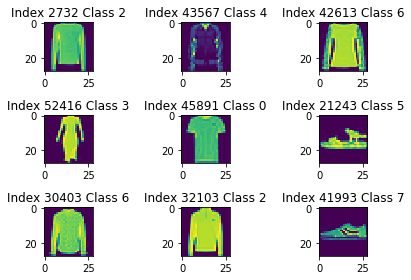

In [3]:
np.random.seed(0);
indices = list(np.random.randint(m_train,size=9))
print(indices)
for i in range(len(indices)):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28),interpolation='none' )
    plt.title("Index {} Class {}".format(indices[i], Y_train[indices[i]]))
    plt.tight_layout()

In [4]:
x_train=X_train.reshape(60000,28,28).copy()
x_test=X_test.reshape(10000,28,28).copy()


In [5]:
print("x_train-shape:",x_train.shape)
print("x_test-shape:",x_test.shape)

x_train-shape: (60000, 28, 28)
x_test-shape: (10000, 28, 28)


In [6]:
# function for fliping the image
def data_augmentation(x_train):
    x_train_aug = x_train
    def flip_image(x_train):
        x_flip =[]   
        for i in range(len(x_train)):
            flipped_img = np.fliplr(x_train[i])
            x_flip.append(flipped_img)
        return x_flip  


# function for horizontal shifting
    def horizontal_shift(x_train):
        x_shift=[]
        WIDTH =28
        HEIGHT =28
        for k in range(len(x_train)):
            for j in range(WIDTH):
                for i in range(HEIGHT):
                    if i < HEIGHT -20:
                        x_train[k][j][i] = x_train[k][j][i+20]
                        x_shift.append(x_train[k])
        return x_shift


# function for adding random noise
    def noise_(x_train):
        m  = len(x_train)
        HEIGHT = 28
        WIDTH  =28
        noise = np.random.randint( 5,size = (m, 28, 28), dtype = 'uint8')
        for i in range(m):
            for j in range(WIDTH):
                for k in range(HEIGHT):
                    if (x_train[i][j][k] <=250):
                        x_train[i][j][k] += noise[i][j][k]
        return x_train


# function for rotating image
    def image_rotation(x_train):
        length,rows,cols = x_train.shape
        rotate_image=[]
        for i in range(length):
            M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
            dst = cv2.warpAffine(x_train[i],M,(cols,rows))
            rotate_image.append(dst)
        return rotate_image

# color shifting of the image
    def color_shift(x_train):
        color_contrast=[]
        length,rows,columns =  x_train.shape
        for k in range (length):
            for i in range(28):
                for j in range(28):
                    x_train[k][i][j] = x_train[k][i][j]-8
            color_contrast.append(x_train[k])             
                    
        return color_contrast
    
    flip_data = flip_image(x_train)
    x_train_aug = np.vstack((x_train_aug,flip_data))
    #h_shift    = horizontal
    #x_train_aug= np.vstack((x_train_aug,h_shift))
    noise_data = noise_(x_train)
    x_train_aug= np.vstack((x_train_aug,noise_data))
    rotate_image = image_rotation(x_train)
    x_train_aug= np.vstack((x_train_aug,rotate_image))
    color_contrast = color_shift(x_train)
    x_train_aug= np.vstack((x_train_aug,color_contrast))
    return x_train_aug

In [7]:
x_train_aug = data_augmentation(x_train)
x_train_aug.shape

(300000, 28, 28)

In [8]:
def y_augmentation(y_train):
    y_list =np.array(Y_train).tolist()
    #print(type(y_list))
    num_of_transformations =int(len(x_train_aug)/len(x_train))
    y_list = y_list*num_of_transformations
    y_train = np.array(y_list)
    y_one_hot = np.eye(10)[y_train]
    y_one_hot
    return y_one_hot
   

In [9]:
y_train = y_augmentation(Y_train)
print(len(y_train))
y_train.shape

300000


(300000, 10)

# Building CNN model


In [10]:
import tensorflow as tf

In [11]:
train_X = x_train_aug.reshape(-1, 28, 28, 1)
train_X.shape

(300000, 28, 28, 1)

In [12]:
n_classes = 10

In [13]:

x = tf.placeholder("float", [None, 28,28,1])
y = tf.placeholder("float", [None, n_classes])
training_iters = 200 
learning_rate = 0.001 
batch_size = 200

In [14]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')


In [15]:
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W6', shape=(128,n_classes), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(10), initializer=tf.contrib.layers.xavier_initializer()),
}



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
x_aug = tf.cast(train_X,tf.float32)
def conv_net(x, weights, biases):  

    # here we call the conv2d function we had defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    print(conv1.shape)
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 14*14 matrix.
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, weights wc2 and bias bc2.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    print(conv2.shape)
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 7*7 matrix.
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    print(conv3.shape)
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 4*4.
    conv3 = maxpool2d(conv3, k=2)
    print(conv3.shape)


    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    print(fc1.shape)
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    print(fc1.shape)
    fc1 = tf.nn.relu(fc1)
    print(fc1.shape)
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out


In [28]:
#pred = conv_net(x_train_aug, weights, biases)
print(x_aug)
weights['wc1'].dtype
biases["bc1"].dtype

Tensor("Cast_2:0", shape=(300000, 28, 28, 1), dtype=float32)


tf.float32_ref

In [29]:
print(weights['wc1'])

<tf.Variable 'W0:0' shape=(3, 3, 1, 32) dtype=float32_ref>


In [33]:
pred = conv_net(x, weights, biases)


(?, 28, 28, 32)
(?, 14, 14, 32)
(?, 14, 14, 64)
(?, 7, 7, 64)
(?, 7, 7, 128)
(?, 4, 4, 128)
(?, 2048)
(?, 128)
(?, 128)


In [40]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [41]:
#Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

#calculate accuracy across all the given images and average them out. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [42]:
# Initializing the variables
init = tf.global_variables_initializer()

In [43]:
m = int(len(x_train_aug)/batch_size)
print(m)

1500


In [ ]:
iterations =20
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    
    for i in range(iterations):
        for batch in range(m):
            batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
            batch_y = y_train[batch*batch_size:min((batch+1)*batch_size,len(y_train))]    
            # Run optimization op (backprop).
                # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={x: batch_x,
                                                              y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y})
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        print("Optimization Finished!")

        # Calculate accuracy for all 10000 mnist test images
        #test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
        #train_loss.append(loss)
        #test_loss.append(valid_loss)
        #train_accuracy.append(acc)
        #test_accuracy.append(test_acc)
        #print("Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()